**1. Здійсніть імпорт необхідних пакетів.**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.datasets import fetch_california_housing

**2. Завантажте набір даних California Housing**

In [3]:
california_data = fetch_california_housing(as_frame=True)
df = california_data.frame
print(df.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


**3. Виконайте етапи з додаткової обробки даних, а саме:**

3.1. Проведіть очистку від викидів для колонок AveRooms, AveBedrms, AveOccup та Population.

In [4]:
columns_to_check = ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']
z_scores = df[columns_to_check].apply(zscore)
filtered_df = df[(z_scores < 3).all(axis=1)]

print(f"Original DataFrame shape: {df.shape}")
print(f"New DataFrame shape after removing outliers: {filtered_df.shape}")

Original DataFrame shape: (20640, 9)
New DataFrame shape after removing outliers: (20135, 9)


3.2. Видаліть із набору даних одну ознаку із тих, які мають високу кореляцію між собою.

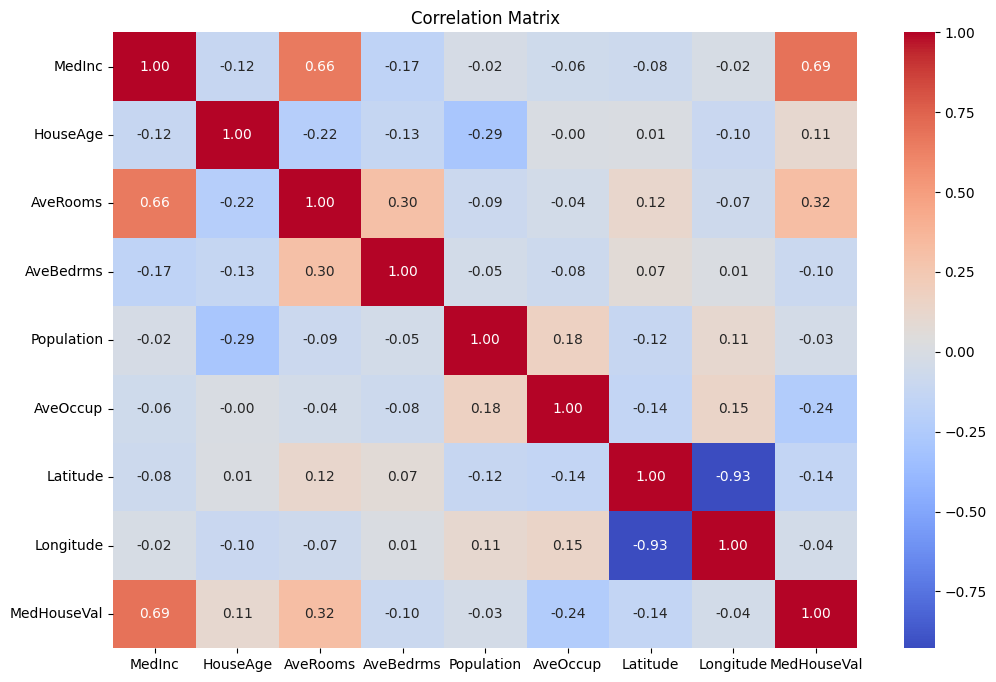

Highly correlated pairs:
Latitude   Longitude    0.927871
Longitude  Latitude     0.927871
dtype: float64
Updated DataFrame after removing highly correlated feature: (20135, 8)


In [5]:
correlation_matrix = filtered_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

high_correlation_threshold = 0.9

high_corr_pairs = (correlation_matrix
                   .abs()
                   .unstack()
                   .sort_values(kind="quicksort", ascending=False))

high_corr_pairs = high_corr_pairs[high_corr_pairs < 1]

print("Highly correlated pairs:")
print(high_corr_pairs[high_corr_pairs > high_correlation_threshold])

if 'AveRooms' in filtered_df.columns:
    filtered_df = filtered_df.drop('AveRooms', axis=1)

print(f"Updated DataFrame after removing highly correlated feature: {filtered_df.shape}")


**4. Розбийте вхідний набір даних на навчальну і тестову вибірки за допомогою методу train_test_split() з пакета sklearn.**


In [6]:
X = filtered_df.drop('MedHouseVal', axis=1)
y = filtered_df['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

Training set shape: X_train: (16108, 7), y_train: (16108,)
Test set shape: X_test: (4027, 7), y_test: (4027,)


**5. Здійсніть нормалізацію ознак за допомогою об’єкту StandardScaler з пакета sklearn.**

In [7]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print(X_train_scaled.head())

     MedInc  HouseAge  AveBedrms  Population  AveOccup  Latitude  Longitude
0 -0.794098 -0.957789   0.651022    0.792934 -0.795716 -0.724357   1.001257
1  0.235746  1.608370   0.040000    0.114855 -0.953534 -0.752457   0.557685
2 -0.429769  0.726253  -0.858866   -0.012899  1.443291  0.853895  -1.271429
3 -0.839231 -0.396442   0.232321    1.345716 -0.109689  0.863262  -1.301333
4  0.405903  0.405483  -1.124457   -1.044759  0.541464 -0.813339   0.737107


**6. Побудуйте модель за допомогою об’єкту LinearRegression з пакета sklearn.**

In [8]:
model = LinearRegression()

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print("First few predictions:", y_pred[:5])

First few predictions: [2.41535764 2.74551728 1.71007216 2.59390903 1.6382965 ]


**7. Оцініть показники моделі:**

* R-квадрат (коефіцієнт детермінації)
* MAE (середня абсолютна похибка)
* MAPE (cередня абсолютна похибка у відсотках)

In [9]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

r_squared = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"R-squared (Coefficient of Determination): {r_squared:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")


R-squared (Coefficient of Determination): 0.6516
Mean Absolute Error (MAE): 0.5068
Mean Absolute Percentage Error (MAPE): 0.2979


### Порівняння нових метрик з попередніми результатами:

1. **R-квадрат (R²)**:
   - **Нова модель**: 0.6516
   - **Попередня модель**: 0.61
   - **Інтерпретація**: Нова модель пояснює трохи більше варіацій у цільовій змінній, ніж попередня модель. Більше значення R² означає, що ця модель краще підходить для даних порівняно з попередньою версією.

2. **Середня абсолютна похибка (MAE)**:
   - **Нова модель**: 0.5068
   - **Попередня модель**: 0.52
   - **Інтерпретація**: Нова модель має нижче значення MAE, що означає, що вона робить більш точні передбачення в середньому порівняно з попередньою моделлю. Різниця невелика, але все ж є покращення.

3. **Середня абсолютна похибка у відсотках (MAPE)**:
   - **Нова модель**: 0.2979 (29.79%)
   - **Попередня модель**: 0.31 (31%)
   - **Інтерпретація**: MAPE для нової моделі трохи краще, що означає, що відсоткова похибка у передбаченнях зменшилася на приблизно 1.21%. Це свідчить про загальне покращення точності передбачень моделі.

### Висновок:

Нова модель показує **незначні покращення** за всіма оціночними метриками. Однак важливим фактором у цьому покращенні є застосування методу **zscore()** для видалення викидів з таких колонок, як **AveRooms**, **AveBedrms**, **AveOccup**, та **Population**. Видалення викидів допомогло позбутися екстремальних значень, які могли негативно впливати на продуктивність попередньої моделі.

Зокрема:
- Значення **R²** вказує на те, що нова модель краще пояснює варіації в даних завдяки очищенню від викидів.
- Значення **MAE** та **MAPE** свідчать про покращення точності передбачень, оскільки модель більше не схильна до впливу екстремальних значень, які були видалені.

Загалом, коригування, зроблені під час очистки даних за допомогою **zscore()**, сприяли цьому покращенню метрик, підвищивши точність і якість передбачень моделі.